In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.2 MB/s eta 0:00:00


In [2]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel

import torch
from torch import cuda
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'

device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [84]:
manually_testdata=pd.read_csv('/content/gdrive/MyDrive/NLPproject/manually_annotated_dataset - Sheet1.csv',on_bad_lines='skip')
manually_testdata = shuffle(manually_testdata)
manually_testdata  = manually_testdata[manually_testdata['text'].notna()]
manually_testdata= manually_testdata.reset_index(drop=True)
manually_testdata['toxic']=manually_testdata['toxic'].astype(int)
manually_testdata['sarcastic']=manually_testdata['sarcastic'].astype(int)
manually_testdata

,text,toxic,sarcastic
0,Shut up your nazi ass,1,0
1,Software development is a very difficult job,0,0
2,Black people should not be given bank loan,1,0
3,Your mother is a filthy bitch,1,0
4,I'm craving pizza right now. I might have to o...,0,0
...,...,...,...
165,Having children makes you no more a parent tha...,0,1
166,I just saw a really inspiring TED Talk,0,0
167,Not everyone wants money. Some people wants lo...,0,1
168,It was a long and tiring day for me. I need a ...,0,0


In [46]:
zero_col_data=pd.read_csv('/content/gdrive/MyDrive/NLPproject/processed_abusive_sarcasm_data.csv',on_bad_lines='skip')
zero_col_data = shuffle(zero_col_data)
zero_col_data  = zero_col_data[zero_col_data['processed_text'].notna()]
zero_col_data= zero_col_data.reset_index(drop=True)
zero_col_data['toxic']=zero_col_data['toxic'].astype(int)
zero_col_data['sarcastic']=zero_col_data['sarcastic'].astype(int)
zero_col_data

,text,toxic,sarcastic,processed_text
0,Ryan Reynolds: he did one of my favorite movie...,0,1,ryan reynolds one favorite movie bury course d...
1,For people who don't know what a telomere is i...,0,1,people know telomere dna degrades dna degrades...
2,"I'm going to be honest, here - I didn't read t...",0,0,go honest read second paragraph thoroughly sti...
3,Interestingly Saddam said he was going to star...,0,1,interestingly saddam say go start sell oil pet...
4,"In the '80s, we used to hang around an arcade/...",0,1,use hang around arcade bar school unemployed l...
...,...,...,...,...
408929,Geno Smith? You mean the only QB to have a per...,0,0,geno smith mean qb perfect passer rating game ...
408930,Idaho state Sen. John McGee (R) was arrested o...,0,1,idaho state sen john mcgee r arrest charge dui...
408931,the graceful slick is non other than an ung...,1,0,graceful slick non ungraceful dick
408932,Legal Alternatives With Calming Effect I've be...,0,1,legal alternative calm effect smoke marijuana ...


In [48]:
pred_col_data=pd.read_csv('/content/gdrive/MyDrive/NLPproject/processed_abusive_sarcasm_data_with_prediction.csv',on_bad_lines='skip')
pred_col_data = shuffle(pred_col_data)
pred_col_data  = pred_col_data[pred_col_data['processed_text'].notna()]
pred_col_data= pred_col_data.reset_index(drop=True)
pred_col_data=pred_col_data.drop(['Unnamed: 0'],axis=1)
pred_col_data['toxic']=pred_col_data['toxic'].astype(int)
pred_col_data['sarcastic']=pred_col_data['sarcastic'].astype(int)
pred_col_data

,text,toxic,sarcastic,processed_text
0,redirect talk international orange chorale of ...,0,0,redirect talk international orange chorale san...
1,Out of the Loop: What's up with the 'Chili's o...,1,0,loop chili th lamar joke joke
2,What Aircraft were you meant to fly F-14 Tomca...,1,0,aircraft mean fly f tomcat fine p
3,@rlfclifestyle wtf that bitch was driving arou...,1,1,rlfclifestyle wtf bitch drive around drunk
4,Just one of those designer things? Everybody i...,0,1,one designer thing everybody wrong distract sh...
...,...,...,...,...
408929,image alkett and rhinemetall borsig s heuschre...,0,0,image alkett rhinemetall borsig heuschrecke jp...
408930,I honestly have no clue what #7 even is suppos...,1,1,honestly clue even suppose say see use serious...
408931,recent changes you just reverted back to me on...,0,0,recent change revert back article cuesh notice...
408932,redirect talk filibuster in the united states ...,0,0,redirect talk filibuster united state senate


In [49]:
def train_test_split(df, train_percent=0.7, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent*m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [50]:
zero_col_train,zero_col_test =train_test_split(zero_col_data, seed=123)
pred_col_train,pred_col_test =train_test_split(pred_col_data, seed=123)

In [51]:
zero_col_train_X=zero_col_train['processed_text']
zero_col_train_y=zero_col_train[['toxic', 'sarcastic']]
zero_col_test_X=zero_col_test['processed_text']
zero_col_test_y=zero_col_test[['toxic', 'sarcastic']]
pred_col_train_X=pred_col_train['processed_text']
pred_col_train_y=pred_col_train[['toxic', 'sarcastic']]
pred_col_test_X=pred_col_test['processed_text']
pred_col_test_y=pred_col_test[['toxic', 'sarcastic']]

In [52]:
zero_col_train_X=zero_col_train_X.reset_index(drop=True)
zero_col_train_y=zero_col_train_y.reset_index(drop=True)
zero_col_test_X=zero_col_test_X.reset_index(drop=True)
zero_col_test_y=zero_col_test_y.reset_index(drop=True)
pred_col_train_X=pred_col_train_X.reset_index(drop=True)
pred_col_train_y=pred_col_train_y.reset_index(drop=True)
pred_col_test_X=pred_col_test_X.reset_index(drop=True)
pred_col_test_y=pred_col_test_y.reset_index(drop=True)

In [53]:
zero_col_train_y=zero_col_train_y.to_numpy()
zero_col_test_y=zero_col_test_y.to_numpy()
pred_col_train_y=pred_col_train_y.to_numpy()
pred_col_test_y=pred_col_test_y.to_numpy()

In [85]:
mt_X=manually_testdata['text']
mt__y=manually_testdata[['toxic', 'sarcastic']]

In [86]:
mt__y=mt__y.to_numpy()

In [8]:
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [9]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = torch.nn.Linear(768, NUM_OUT)
        self.dropout = torch.nn.Dropout(0.3)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [10]:
def loss_fn(outputs, targets):
    with torch.autocast('cuda'):
      loss=torch.nn.BCEWithLogitsLoss()(outputs, targets.float())
    return loss

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in testing_loader:
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [28]:
def gradio_fn(model, data):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
    return torch.stack(fin_outputs)

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 2
LEARNING_RATE = 2e-05


test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }   

In [54]:
zero_col_training_data = MultiLabelDataset(zero_col_train_X, torch.from_numpy(zero_col_train_y), tokenizer, MAX_LEN)
zero_col_test_data = MultiLabelDataset(zero_col_test_X, torch.from_numpy(zero_col_test_y), tokenizer, MAX_LEN)
pred_col_training_data = MultiLabelDataset(pred_col_train_X, torch.from_numpy(pred_col_train_y), tokenizer, MAX_LEN)
pred_col_test_data = MultiLabelDataset(pred_col_test_X, torch.from_numpy(pred_col_test_y), tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

zero_col_training_loader = torch.utils.data.DataLoader(zero_col_training_data, **train_params)
zero_col_testing_loader = torch.utils.data.DataLoader(zero_col_test_data, **test_params)
pred_col_training_loader = torch.utils.data.DataLoader(pred_col_training_data, **train_params)
pred_col_testing_loader = torch.utils.data.DataLoader(pred_col_test_data, **test_params)

In [87]:
manualtestdata=MultiLabelDataset(mt_X, torch.from_numpy(mt__y), tokenizer, MAX_LEN)
manual_Tester = torch.utils.data.DataLoader(manualtestdata, **test_params)

In [55]:
import pickle
zc_pickled_model = pickle.load(open('/content/gdrive/MyDrive/NLPproject/zc_model.pkl', 'rb'))
pc_pickled_model = pickle.load(open('/content/gdrive/MyDrive/NLPproject/pc_model.pkl', 'rb'))

In [56]:
zc_guess, zc_targs = validation(zc_pickled_model, zero_col_testing_loader)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-8-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


In [57]:
attributes=['toxic','sarcastic']

Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Zero Column Datatset - AUROC')

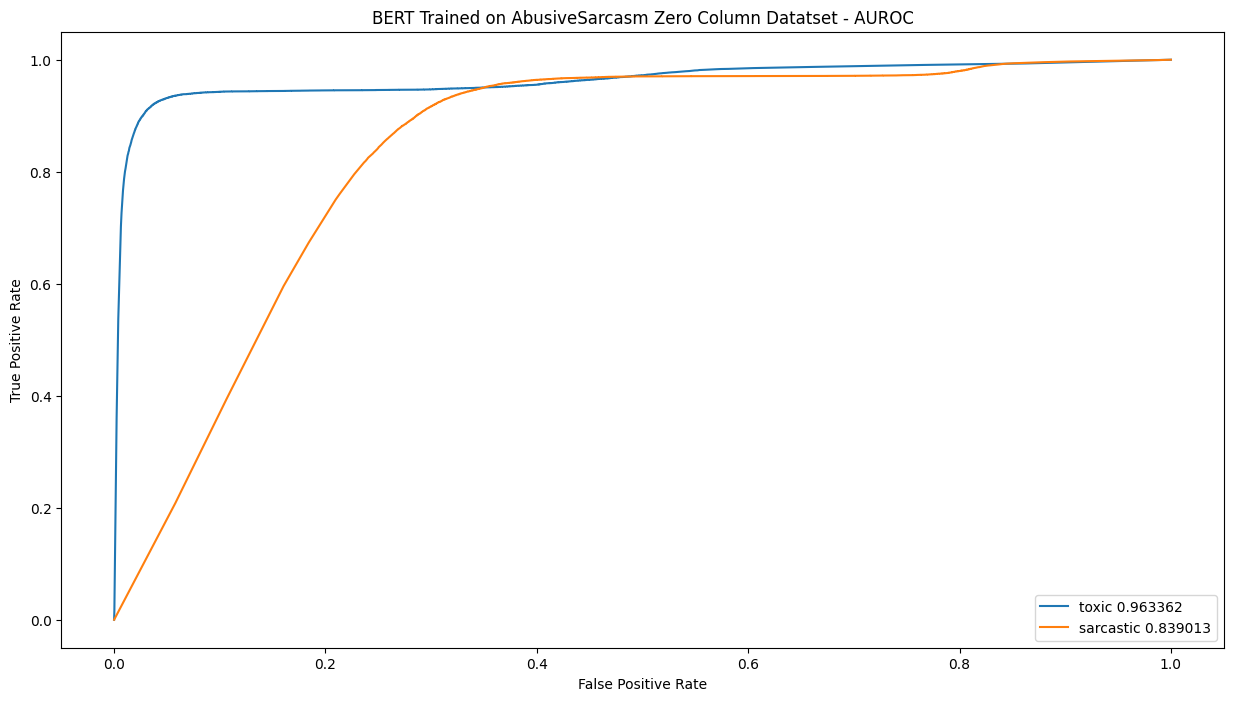

In [128]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      zc_targs[:,i], zc_guess[:, i])
  auc = metrics.roc_auc_score(
      zc_targs[:,i], zc_guess[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Zero Column Datatset - AUROC')

In [59]:
zc_label_predictions=[]
for i in range(len(zc_guess)):
  temp=[]
  if zc_guess[i][0] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  if zc_guess[i][1] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  zc_label_predictions.append(temp)

In [129]:
from sklearn.metrics import classification_report
print(classification_report(zc_label_predictions, zc_targs, target_names=['toxic_report', 'sarcastic_report']))
print('arracy on test set {}'.format(accuracy_score(zc_label_predictions, zc_targs)))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

    toxic_report       0.91      0.83      0.87     19863
sarcastic_report       0.94      0.49      0.64     59206

       micro avg       0.93      0.57      0.71     79069
       macro avg       0.93      0.66      0.75     79069
    weighted avg       0.93      0.57      0.70     79069
     samples avg       0.37      0.37      0.37     79069

arracy on test set 0.7072733349092362


[[101264   1554]
 [  3451  16412]]


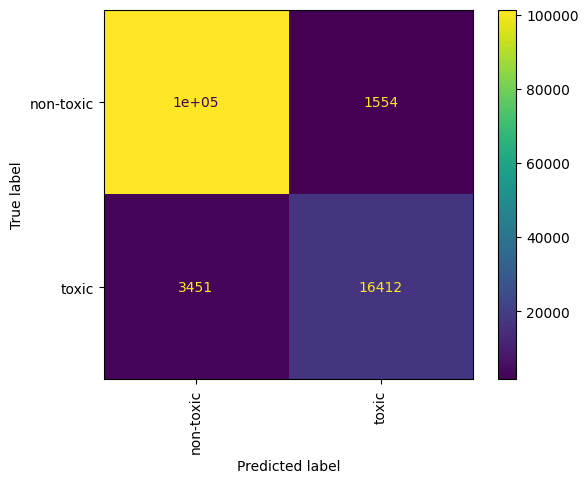

[[61666  1809]
 [30458 28748]]


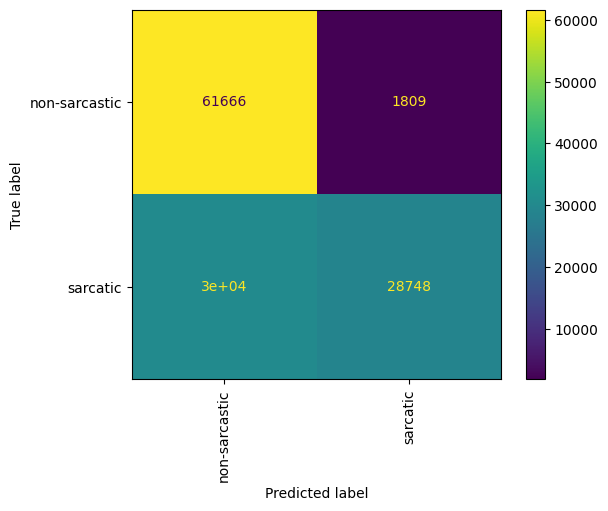

In [83]:
import sklearn.metrics as skm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = skm.multilabel_confusion_matrix(zc_label_predictions, zc_targs,)
for i in range(2):
    if i==0:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-toxic','toxic'])
    else:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-sarcastic','sarcatic'])
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()

In [66]:
pc_guess, pc_targs = validation(pc_pickled_model, pred_col_testing_loader)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-8-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Predict Column Datatset - AUROC')

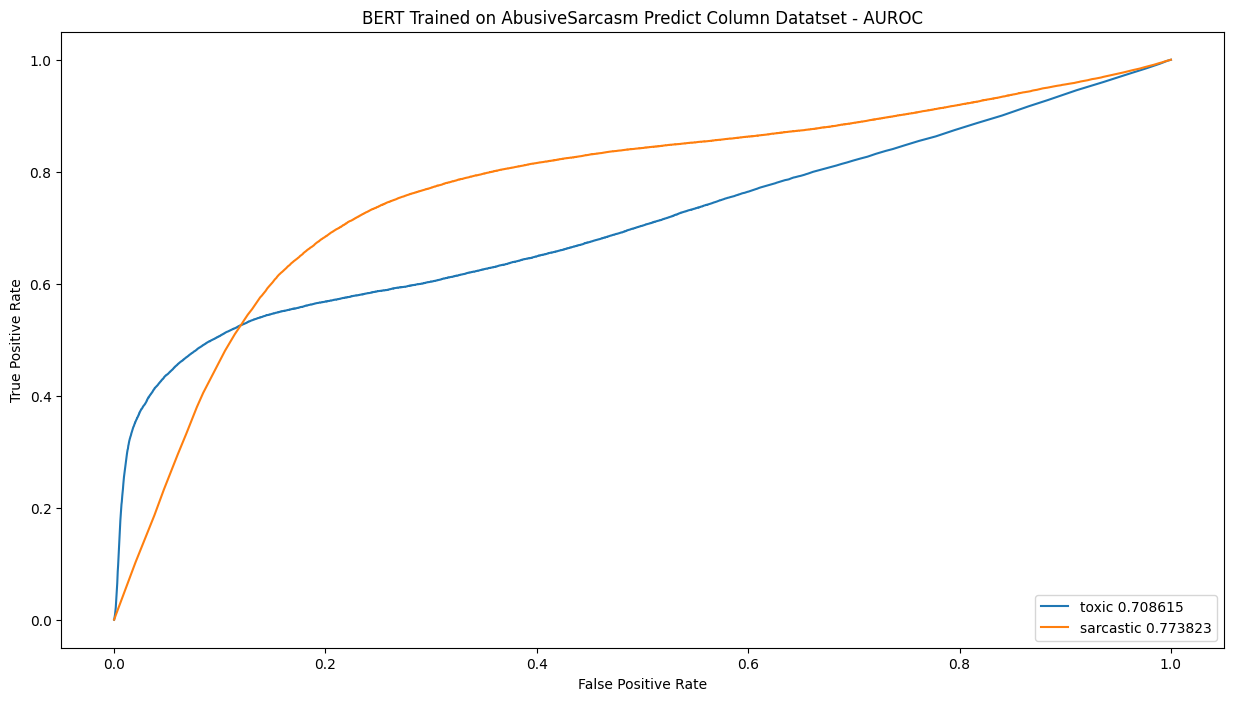

In [130]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      pc_targs[:,i], pc_guess[:, i])
  auc = metrics.roc_auc_score(
      pc_targs[:,i], pc_guess[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Predict Column Datatset - AUROC')

In [89]:
pc_label_predictions=[]
for i in range(len(pc_guess)):
  temp=[]
  if pc_guess[i][0] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  if pc_guess[i][1] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  pc_label_predictions.append(temp)

In [131]:
from sklearn.metrics import classification_report
print(classification_report(pc_label_predictions, pc_targs,target_names=['toxic_report', 'sarcastic_report']))
print('arracy on test set {}'.format(accuracy_score(pc_label_predictions, pc_targs)))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

    toxic_report       0.45      0.74      0.56     20421
sarcastic_report       0.77      0.63      0.69     58953

       micro avg       0.64      0.66      0.65     79374
       macro avg       0.61      0.68      0.63     79374
    weighted avg       0.69      0.66      0.66     79374
     samples avg       0.38      0.42      0.39     79374

arracy on test set 0.6028480367783112


[[83998 18262]
 [ 5252 15169]]


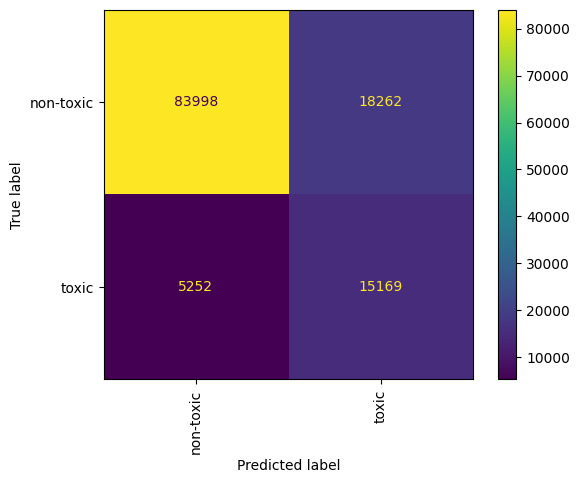

[[52592 11136]
 [21993 36960]]


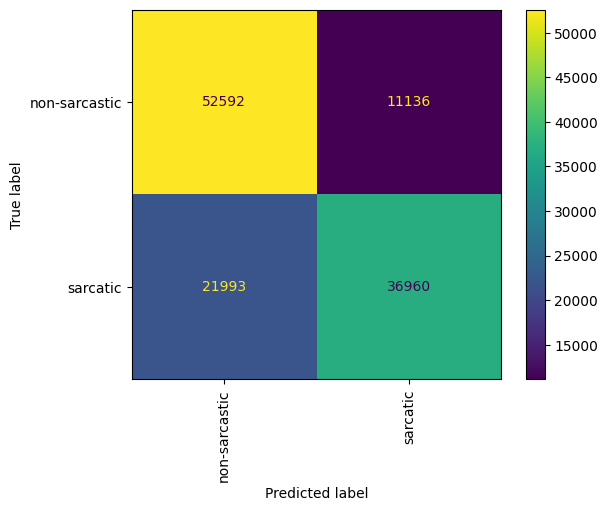

In [93]:
cm = skm.multilabel_confusion_matrix(pc_label_predictions, pc_targs,)
for i in range(2):
    if i==0:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-toxic','toxic'])
    else:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-sarcastic','sarcatic'])
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()

In [94]:
guess1, targs1 = validation(zc_pickled_model, manual_Tester)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-8-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Zero Column Datatset on Manually Annotated Data - AUROC')

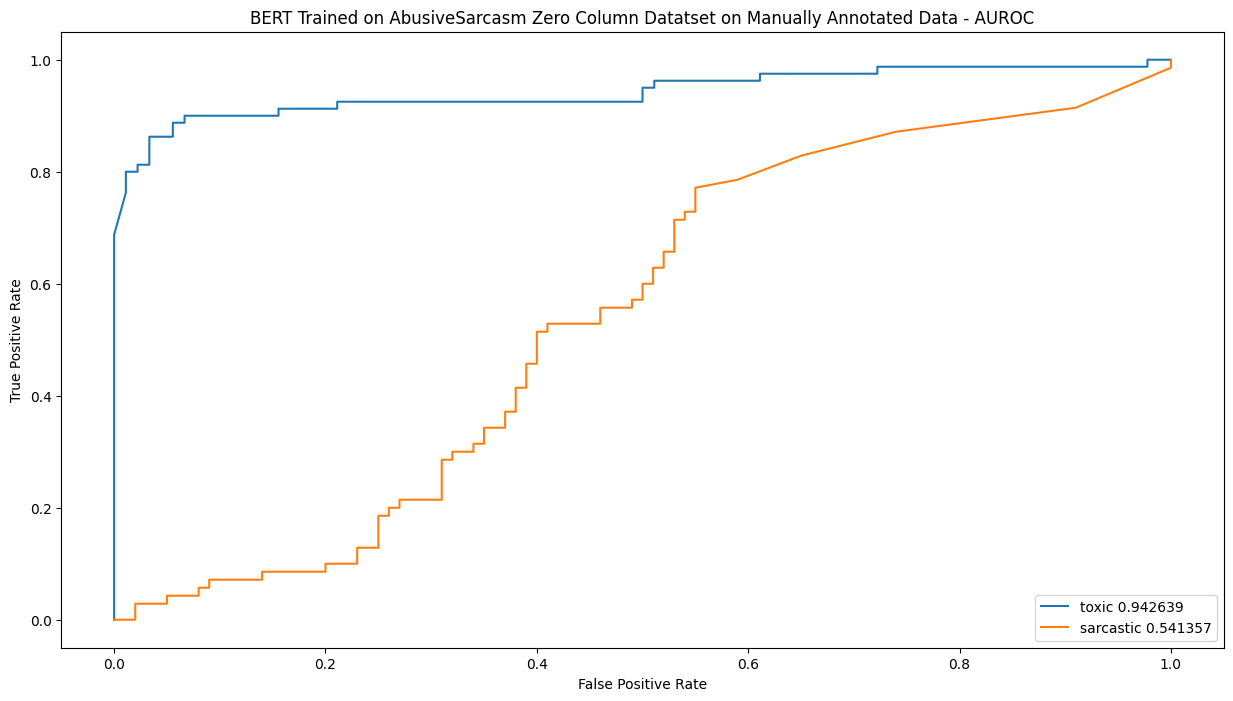

In [132]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      targs1[:,i], guess1[:, i])
  auc = metrics.roc_auc_score(
      targs1[:,i], guess1[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Zero Column Datatset on Manually Annotated Data - AUROC')

In [133]:
mt_label_predictions=[]
for i in range(len(guess1)):
  temp=[]
  if guess1[i][0] > 0.65:
    temp.append(1) 
  else:
    temp.append(0)
  if guess1[i][1] > 0.65:
    temp.append(1) 
  else:
    temp.append(0)
  mt_label_predictions.append(temp)

In [135]:
from sklearn.metrics import classification_report
print(classification_report(mt_label_predictions, targs1,target_names=['toxic', 'sarcastic']))
print('arracy on test set {}'.format(accuracy_score(mt_label_predictions, targs1)))

              precision    recall  f1-score   support

       toxic       0.90      0.90      0.90        80
   sarcastic       0.46      0.45      0.45        71

   micro avg       0.69      0.69      0.69       151
   macro avg       0.68      0.68      0.68       151
weighted avg       0.69      0.69      0.69       151
 samples avg       0.53      0.61      0.56       151

arracy on test set 0.5117647058823529


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[82  8]
 [ 8 72]]


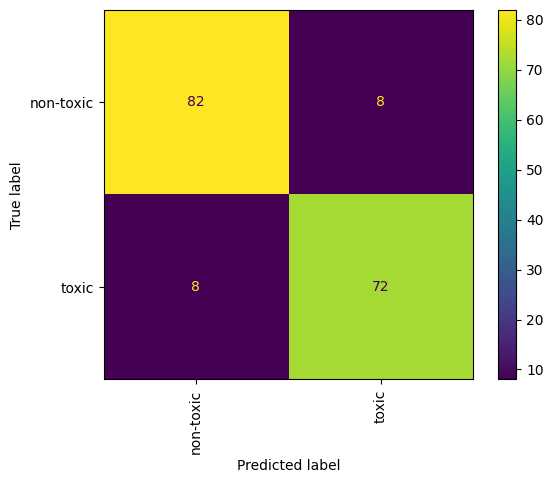

[[61 38]
 [39 32]]


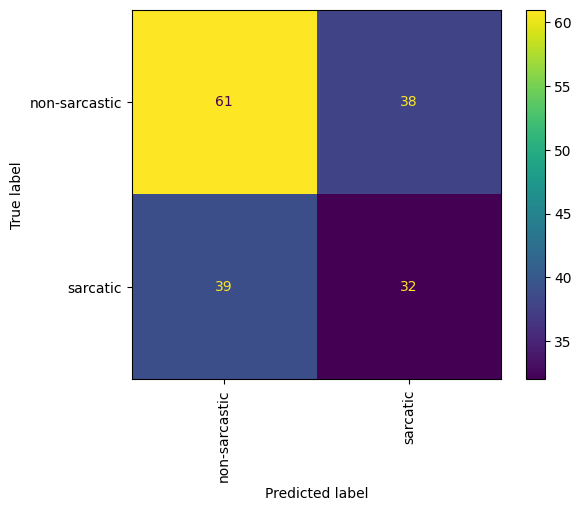

In [114]:
import sklearn.metrics as skm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = skm.multilabel_confusion_matrix(mt_label_predictions, targs1)
for i in range(2):
    if i==0:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-toxic','toxic'])
    else:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-sarcastic','sarcatic'])
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()

In [115]:
guess2, targs2 = validation(pc_pickled_model, manual_Tester)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-8-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Predict Column Datatset on Manually Annotated Data - AUROC')

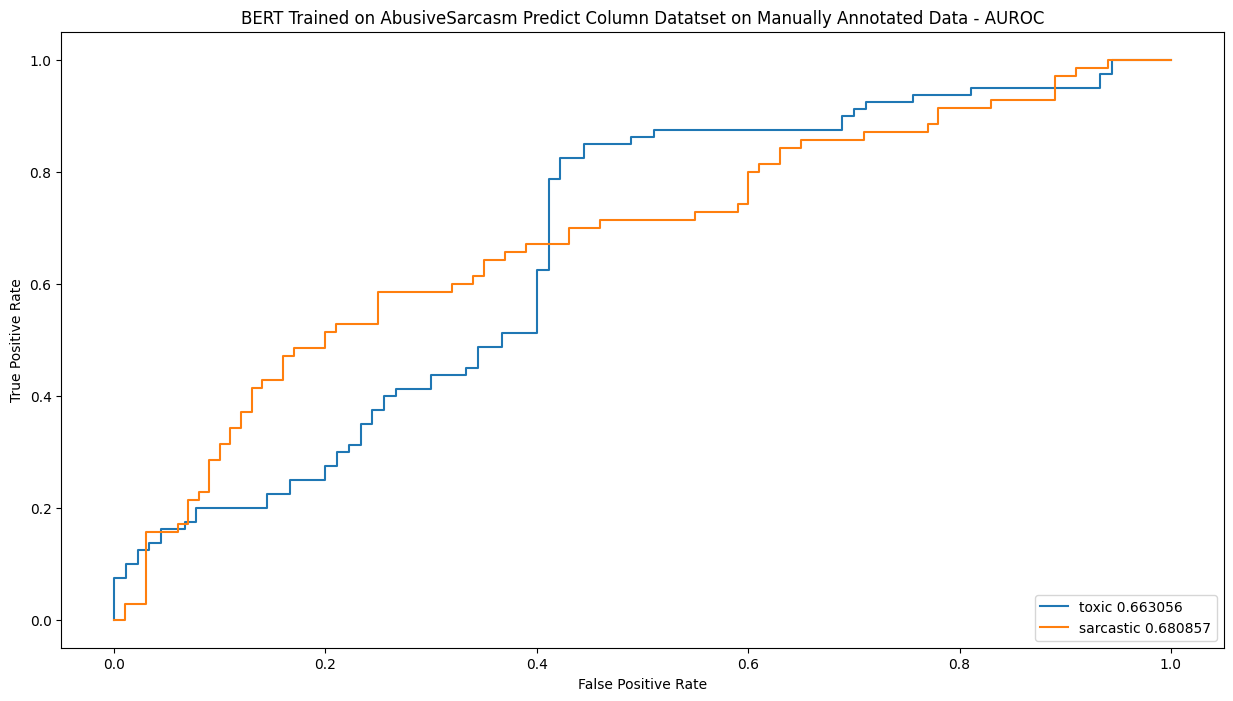

In [138]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      targs2[:,i], guess2[:, i])
  auc = metrics.roc_auc_score(
      targs2[:,i], guess2[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Predict Column Datatset on Manually Annotated Data - AUROC')

In [139]:
mt_label_predictions=[]
for i in range(len(guess2)):
  temp=[]
  if guess2[i][0] > 0.6:
    temp.append(1) 
  else:
    temp.append(0)
  if guess2[i][1] > 0.6:
    temp.append(1) 
  else:
    temp.append(0)
  mt_label_predictions.append(temp)

In [141]:
from sklearn.metrics import classification_report
print(classification_report(mt_label_predictions, targs2,target_names=['toxic', 'sarcastic']))
print('arracy on test set {}'.format(accuracy_score(mt_label_predictions, targs2)))

              precision    recall  f1-score   support

       toxic       0.86      0.61      0.71       114
   sarcastic       0.80      0.48      0.60       117

   micro avg       0.83      0.54      0.66       231
   macro avg       0.83      0.54      0.66       231
weighted avg       0.83      0.54      0.65       231
 samples avg       0.61      0.56      0.56       231

arracy on test set 0.36470588235294116


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[45 11]
 [45 69]]


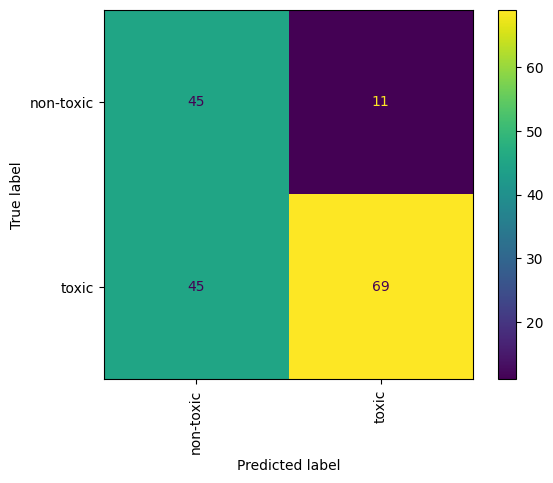

[[39 14]
 [61 56]]


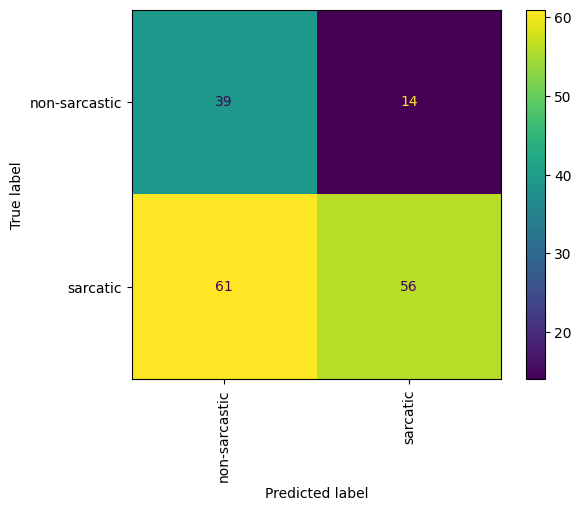

In [127]:
import sklearn.metrics as skm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = skm.multilabel_confusion_matrix(mt_label_predictions, targs2)
for i in range(2):
    if i==0:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-toxic','toxic'])
    else:
      print(cm[i])
      disp = ConfusionMatrixDisplay(cm[i], display_labels=['non-sarcastic','sarcatic'])
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()